# **Weather Forecast with Facebook Prophet**

**Intuition:** We will be creating a model with Facebook's Prophet library to forecast our scraped weather data. Go to: https://facebook.github.io/prophet/ to learn more about Prophet. 

### Importing the libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')
import urllib
import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

### Scraping weather data from Mesowest & creating a dataframe

In [2]:
args = {'start':'201603010000',
'end':'202003010000', # We will be scraping four years of data
'obtimezone':'UTC',
'vars':'air_temp',
'stids':'KVIS', # This ID represents the weather station at Visalia Municipal Airport near California
'units':'temp|C',
'token':'d07a1d10618447c48e2dfea41dfc52de'}

apiString = urllib.parse.urlencode(args)
url = "http://api.mesowest.net/v2/stations/timeseries"
full_url = '{}?{}'.format(url, apiString)
response = urllib.request.urlopen(full_url)
response_dict = json.loads(response.read())

date_time = response_dict['STATION'][0]['OBSERVATIONS']['date_time']
temperature = response_dict['STATION'][0]['OBSERVATIONS']['air_temp_set_1']
dataset = pd.DataFrame(temperature, index=pd.to_datetime(date_time), columns = ['Temperature'])
dataset.head()

,Temperature
2016-03-01 00:56:00+00:00,20.6
2016-03-01 01:56:00+00:00,18.3
2016-03-01 02:56:00+00:00,15.0
2016-03-01 03:56:00+00:00,14.4
2016-03-01 04:56:00+00:00,13.9


### Resampling the data based on days.

In [3]:
dataset_res = dataset.resample('D').mean()
dataset_res.count()

Temperature    1462
dtype: int64

In [4]:
dataset_res.index

DatetimeIndex(['2016-03-01 00:00:00+00:00', '2016-03-02 00:00:00+00:00',
               '2016-03-03 00:00:00+00:00', '2016-03-04 00:00:00+00:00',
               '2016-03-05 00:00:00+00:00', '2016-03-06 00:00:00+00:00',
               '2016-03-07 00:00:00+00:00', '2016-03-08 00:00:00+00:00',
               '2016-03-09 00:00:00+00:00', '2016-03-10 00:00:00+00:00',
               ...
               '2020-02-21 00:00:00+00:00', '2020-02-22 00:00:00+00:00',
               '2020-02-23 00:00:00+00:00', '2020-02-24 00:00:00+00:00',
               '2020-02-25 00:00:00+00:00', '2020-02-26 00:00:00+00:00',
               '2020-02-27 00:00:00+00:00', '2020-02-28 00:00:00+00:00',
               '2020-02-29 00:00:00+00:00', '2020-03-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1462, freq='D')

### Plotting the dataset

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


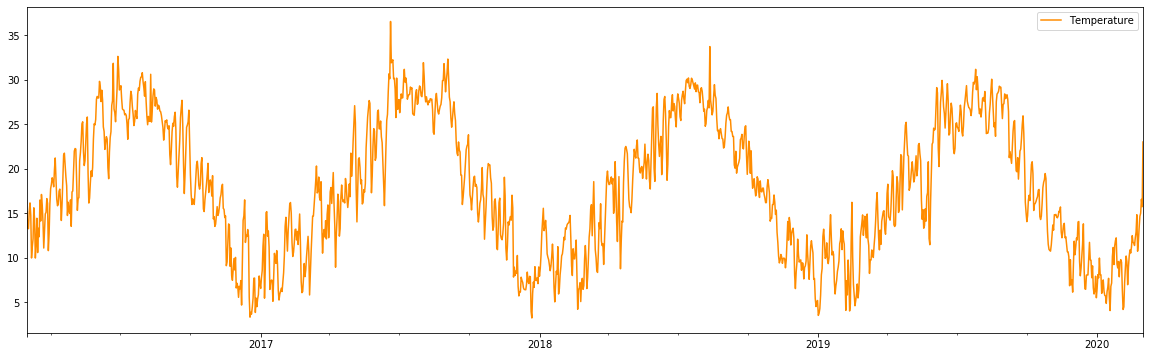

In [5]:
pd.plotting.register_matplotlib_converters() # Run if encounter error while plotting
dataset_res.plot(figsize = (20, 6), color = 'darkorange')

### Checking for stationarity with ADFuller Test

In [6]:
def adf_test(series, title = ''): # Pass in a time-series & an optional title. Returns an ADF Report.
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag = 'AIC') # **dropna()** handles differenced data.
    labels = ['ADF Test Statistics', 'p-value', 'Number of Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index = labels)
    
    for key, value in result[4].items():
        out[f'Critical Value (%s)'% key] = value
    print(out.to_string()) # **to_string** removes the line **dtype: float64**
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis',
              '\nReject the null hypothesis',
              '\nData has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis',
              '\nFail to reject the null hypothesis',
              '\nData has a unit root & is non-stationary')
adf_test(dataset_res['Temperature'], title = 'Temperature')

Augmented Dickey-Fuller Test: Temperature
ADF Test Statistics              -2.190286
p-value                           0.209790
Number of Lags Used              16.000000
Number of Observations Used    1445.000000
Critical Value (1%)              -3.434884
Critical Value (5%)              -2.863542
Critical Value (10%)             -2.567836
Weak evidence against the null hypothesis 
Fail to reject the null hypothesis 
Data has a unit root & is non-stationary


### ETS Decomposition

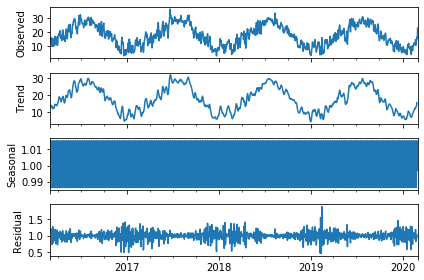

In [7]:
result = seasonal_decompose(dataset_res['Temperature'], model='multiplicative')  # model='mul' also works
result.plot();

### Formating the data to make it compatible for Prophet

In [8]:
dataset_fin = dataset_res['Temperature']
dataset_fin = dataset_fin.reset_index()
dataset_fin.columns = ['ds', 'y']
dataset_fin['ds'] = dataset_fin['ds'].dt.strftime('%Y-%m-%d')
dataset_fin.head()

,ds,y
0,2016-03-01,15.147826
1,2016-03-02,13.355172
2,2016-03-03,13.258065
3,2016-03-04,15.208000
4,2016-03-05,16.155556


### Splitting the data into training & test sets

In [0]:
train = dataset_fin.iloc[:len(dataset_fin)-30]
test = dataset_fin.iloc[len(dataset_fin)-30:] # Last 30 Days

### Fitting a Prophet model onto the training set

In [10]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicting the Test results


In [11]:
future = model.make_future_dataframe(periods = len(test), freq = 'D') # Placeholder for the predictions
predictions = model.predict(future)
predictions.tail(len(test))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1432,2020-02-01,17.243027,6.147868,13.143973,17.243027,17.243027,-7.670668,-7.670668,-7.670668,-0.040658,-0.040658,-0.040658,-7.630010,-7.630010,-7.630010,0.0,0.0,0.0,9.572359
1433,2020-02-02,17.242280,6.083041,13.035172,17.242280,17.242280,-7.620338,-7.620338,-7.620338,-0.035253,-0.035253,-0.035253,-7.585085,-7.585085,-7.585085,0.0,0.0,0.0,9.621942
1434,2020-02-03,17.241533,5.995328,12.717946,17.241533,17.241533,-7.645833,-7.645833,-7.645833,-0.100176,-0.100176,-0.100176,-7.545657,-7.545657,-7.545657,0.0,0.0,0.0,9.595700
1435,2020-02-04,17.240786,6.187680,13.140741,17.240786,17.240786,-7.548385,-7.548385,-7.548385,-0.036011,-0.036011,-0.036011,-7.512374,-7.512374,-7.512374,0.0,0.0,0.0,9.692401
1436,2020-02-05,17.240039,6.412321,13.413601,17.240039,17.240039,-7.275861,-7.275861,-7.275861,0.209929,0.209929,0.209929,-7.485789,-7.485789,-7.485789,0.0,0.0,0.0,9.964178
1437,2020-02-06,17.239292,6.458906,13.221064,17.239292,17.239292,-7.330977,-7.330977,-7.330977,0.135369,0.135369,0.135369,-7.466346,-7.466346,-7.466346,0.0,0.0,0.0,9.908316
1438,2020-02-07,17.238545,6.189565,12.941151,17.238545,17.238545,-7.587542,-7.587542,-7.587542,-0.133200,-0.133200,-0.133200,-7.454343,-7.454343,-7.454343,0.0,0.0,0.0,9.651003
1439,2020-02-08,17.237798,6.011050,13.285062,17.237798,17.237798,-7.490577,-7.490577,-7.490577,-0.040658,-0.040658,-0.040658,-7.449919,-7.449919,-7.449919,0.0,0.0,0.0,9.747222
1440,2020-02-09,17.237052,6.134607,13.462164,17.237052,17.237052,-7.488283,-7.488283,-7.488283,-0.035253,-0.035253,-0.035253,-7.453030,-7.453030,-7.453030,0.0,0.0,0.0,9.748768
1441,2020-02-10,17.236305,6.374856,13.153634,17.236305,17.236305,-7.563615,-7.563615,-7.563615,-0.100176,-0.100176,-0.100176,-7.463439,-7.463439,-7.463439,0.0,0.0,0.0,9.672690


### Test vs Prediction Plot

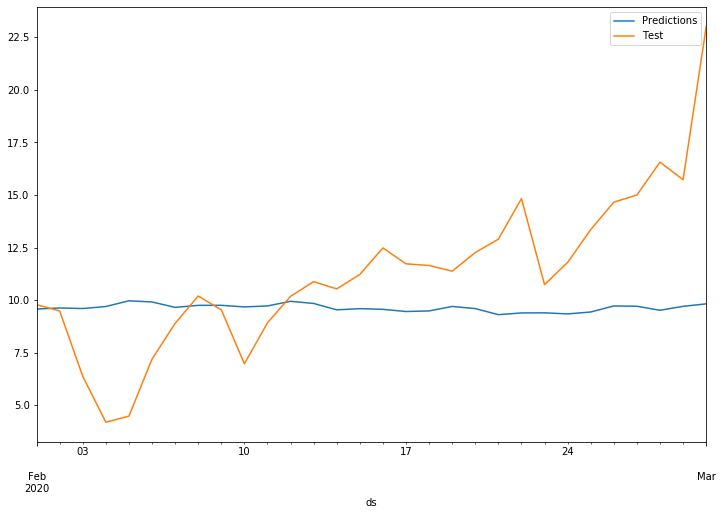

In [12]:
test['ds'] = pd.to_datetime(test['ds'])
ax = predictions.tail(30).plot(x = 'ds', y = 'yhat', label = 'Predictions', figsize = (12, 8), legend = True)
test.plot(x = 'ds', y = 'y', label = 'Test', legend = True, ax = ax)

### RMSE

In [13]:
print('RMSE = %s' % rmse(predictions['yhat'].tail(30), test['y']),
      '\n\nTest Mean = %s' % test['y'].mean(),
      '\n\nPredictions Mean = %s' % predictions['yhat'].tail(30).mean())

RMSE = 4.074788883012155 

Test Mean = 11.226603045275057 

Predictions Mean = 9.629382893257619


### Running Cross-validation with Prophet Diagnostics

In [14]:
# Initial 5 months of training period
initial = 365
initial = str(initial) + ' days'
initial

'365 days'

In [15]:
# Fold every 5 months
period = 365
period = str(period) + ' days'
period

'365 days'

In [16]:
# Forecast 1 month into the future
horizon = 30
horizon = str(horizon) + ' days'
horizon

'30 days'

In [17]:
df_cv = cross_validation(model, initial = initial, period = period, horizon = horizon)
df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-01-01 00:00:00 and 2020-01-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-02,8.323420,5.020848,11.633751,8.782781,2018-01-01
1,2018-01-03,8.622053,4.926775,11.897320,10.290850,2018-01-01
2,2018-01-04,8.460040,4.999579,11.829564,12.698452,2018-01-01
3,2018-01-05,8.346140,4.987057,11.781040,14.070093,2018-01-01
4,2018-01-06,8.312372,4.746780,11.807170,15.554019,2018-01-01
...,...,...,...,...,...,...
85,2020-01-27,9.388298,5.956009,12.894517,9.288988,2020-01-01
86,2020-01-28,9.473324,5.995479,13.010971,8.849096,2020-01-01
87,2020-01-29,9.739341,6.185673,13.014416,9.575862,2020-01-01
88,2020-01-30,9.702427,6.117085,13.199075,7.854938,2020-01-01


### Performance Metrics


In [18]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,8.925396,2.987540,2.367213,0.416006,0.666667
1,4 days,9.585335,3.096019,2.465637,0.312444,0.666667
2,5 days,12.822388,3.580836,2.590682,0.229610,0.666667
3,6 days,13.997500,3.741323,2.795834,0.236112,0.555556
4,7 days,15.794524,3.974232,3.342964,0.293638,0.444444
5,8 days,14.722366,3.836974,3.591590,0.327374,0.444444
6,9 days,12.963466,3.600481,3.244139,0.299005,0.555556
7,10 days,9.145154,3.024096,2.651828,0.276890,0.777778
8,11 days,6.765079,2.600977,2.415865,0.294222,0.888889
9,12 days,6.276409,2.505276,2.300242,0.324824,0.888889


### Cross-validation plot

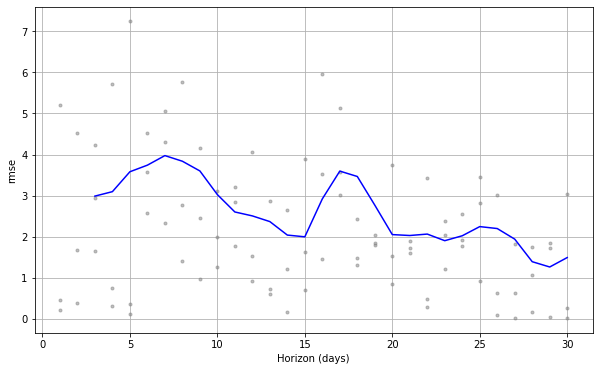

In [19]:
plot_cross_validation_metric(df_cv, metric='rmse');